In [1]:
from sim_functions import *
from helpers import *
from Variational_Functions import *
import pickle
from gpytorch.distributions import MultivariateNormal
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def matrix_norm_dist(V, U, A, n = 10):
       
    mu = A.T.flatten().double()
    prec = torch.kron(torch.inverse(V).double(), torch.inverse(U).double())
    MV1 = torch.distributions.multivariate_normal.MultivariateNormal(mu.double(), precision_matrix= prec.double())
    
    return MV1    
def getTotLik(Y, X, u, t, A):
    J = len(A)
    Z = t.Z
    A_list = t.A_list
    w_list = t.w.float()**2
    theta = t.phi[0]
    nu = t.phi[1]**2
    sig = t.phi[-1]
    lam = t.lam

    #A: num Components x samps
    #$

    #grab the probability of u
    Kmm = get_covxy(Z, Z, theta =  theta, nu = nu)
    Kmmc = CholLinearOperator(TriangularLinearOperator(psd_safe_cholesky(Kmm, jitter = 1e-6)))
    u_prob = MultivariateNormal(torch.zeros(u.shape[0]).cuda(), Kmm).log_prob(u)
    
    #Kmi = torch.inverse(Kmm)
    Kmi = CholLinearOperator(TriangularLinearOperator(to_linear_operator(Kmm).add_jitter(1e-6).cholesky())).inverse().to_dense()
    Kmn_sum = 0
    Knn_sum = 0
    Kxm_list = []
    for i in range(len(A)):
        Xn = A[i].mm(X.T).T
        Kmn_sum += get_covxy(Z, Xn, theta = theta, nu = nu)
        Knn_sum += get_covxy(Xn, Xn, theta = theta, nu = nu)
    
    
    noise_var = torch.eye(Y.shape[0]).cuda()*sig**2
    Ksolveu  = Kmmc.solve(u)
    y_prob = MultivariateNormal(Kmn_sum.T @ Ksolveu, Knn_sum - (1/J)*Kmn_sum.T @ Kmmc.solve(Kmn_sum) + noise_var).log_prob(Y)
    U = torch.eye(A_list[0].shape[0]).cuda()
    A_prob = 0
    for i in range(len(A)):
        #mnorm = matrix_norm_dist(V = torch.eye(X.shape[1]).cuda()*lam[i]**2, U = U, A = A[i])
        #A_prob += mnorm.log_prob(A[i].flatten())
        A_prob +=  torch.distributions.Laplace(0, lam[i]**2).log_prob(A[i].flatten()).sum()
    
    return y_prob + u_prob + A_prob
    


def getVariationalDist(t, X, Y):
    n = X.shape[0]
    Z = t.Z
    A_list = t.A_list
    w_list = t.w.float()**2
    theta = t.phi[0]
    nu = t.phi[1]**2
    sig = t.phi[-1]
    lam = t.lam

    
    Kmm = get_covxy(X = Z, Y = Z, theta = theta, nu = nu)
    phi0 = fphi0(nu, n)
    
    phi1_list = []
    phi2_list = []
    KL_sum = 0
    for i in range(len(A_list)):
        phi1_list.append(sfphi1(X= X, Z = Z, theta = theta, nu = nu, w = w_list[i], A = A_list[i]))
        phi2_list.append(sfphi2(X= X, Z = Z, theta = theta, nu = nu, w = w_list[i], A = A_list[i]))
        KL_sum += skl(A = A_list[i], w = w_list[i], lam = lam[i]**2)
        
    phi1_sum = torch.cat([m[None] for m in phi1_list]).sum(0)
    phi2_trace = torch.cat([m[None] for m in phi2_list]).sum(0)
    
    phi2_sum = 0
    for i in range(len(A_list)):
        for j in range(len(A_list)):
            if i == j:
                phi2_sum += phi2_list[i]
            else:
                phi2_sum += phi1_list[i].mm(phi1_list[j].T)
    
    mFdq1(Y = Y, sig = sig, Kmm = Kmm, phi0 = phi0*len(A_list), 
                 phi1 = phi1_sum, phi2 = phi2_sum, phi2_trace=  phi2_trace)
    
    V = torch.square(1/sig)*phi2_sum + Kmm
    VC = CholLinearOperator(TriangularLinearOperator(to_linear_operator(V).add_jitter(1e-6).cholesky()))
    
    P = torch.square(1/sig)*phi2_sum
    D = Kmm
    W = VC
    y_bar = phi1_sum @ Y
    
    u_mu = Kmm @ VC.solve(y_bar)
    u_Sig = Kmm @ VC.solve(Kmm)
    u_dist = MultivariateNormal(u_mu, u_Sig)
    U = torch.eye(A_list[0].shape[0]).cuda()
    batch_dist = [matrix_norm_dist(V = torch.eye(X.shape[1]).cuda()*w_list[i]**2, U = U, A = A_list[i]) for i in range(len(A_list))]
    
    return u_dist, batch_dist

In [2]:
sample_vec = [300, 400, 500]
folds = 20
nm = 125
D_vec = [20]
d_dict = {}
for D in D_vec:
    s_dict = {}
    for s in sample_vec:
        f_list = []
        for f in range(folds):
            print("dimension {} , fold {}, sample {}".format(D, f, s))
            X, Y, Xtest, Ytest = draw_exp(ntrain = s, ntest = 300, D = D, stride = int(D//3))
            
            gpy_dict = gpy_stats(X = X, Y = Y, Xtest = Xtest, Ytest=  Ytest)


            try:
                vim3_dict = vim_stats(X = X, Y = Y, Xtest = Xtest, Ytest=  Ytest, 
                                        d1 = 4, J = 3,nm = nm, ft = 1.75, iters = 2000, 
                                     verbose = False, lr = .005, retry = True)
            except:
                vim3_dict = vim_stats(X = X, Y = Y, Xtest = Xtest, Ytest=  Ytest, 
                                        d1 = 4, J = 3, nm = nm, ft = 1.75, iters =2000, 
                                        lr = .0025, retry = False)
                
                

            vim3_dict['X'] = X
            vim3_dict['Y'] = Y
            f_dict = {'vim3': vim3_dict}
            #print(f_dict)
            print("-------------------------------")
            f_list.append(f_dict)
            #d_dict[D][s][f]['dpa'] = dpa_dict
            #d_dict[D][s][f]['dle'] = dle_dict
            #print(d_dict[D][s][f])
        s_dict[s] = f_list
        f = open("sim_results/check_s{}_d{}".format(s, D), "wb")
        pickle.dump(s_dict, f)
        f.close()
    d_dict[D] = s_dict
    f = open("sim_results/check_d{}".format(D), "wb")
    pickle.dump(d_dict, f)
    f.close()


dimension 20 , fold 0, sample 300


  0%|          | 0/2000 [00:00<?, ?it/s]

first optimization


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f212ca88950>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f212ca88950>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
  0%|          | 2/2000 [00:00<02:36, 12.76it/s, loss=6.7e+4]


first optimization



KeyboardInterrupt



In [ ]:

store_dict = {}
for s in [300, 400, 500]:
    with open(r"sim_results/check_d20", "rb") as input_file:
        e = pickle.load(input_file)
    s_vals = []
    for i in range(20):
        t = e[20][s][i]['vim3']['model']
        X = e[20][s][i]['vim3']['X'].double()
        Y = e[20][s][i]['vim3']['Y'].double()
        udist, mDist = getVariationalDist(t = t, X =X, Y = Y )
        ratio_list = []

        for i in range(10000):
            udist, mDist = getVariationalDist(t = t, X =X, Y = Y )
            u = udist.rsample()
            A = [mDist[i].rsample().reshape(4, 20)  for i in range(3)]
            Apost = sum([adist.log_prob(A[i].flatten()) for i, adist in enumerate(mDist)])
            upost = udist.log_prob(u)
            loglik = getTotLik(Y= Y, X = X, u = u, A = A, t = t)
            ratio_list.append( (loglik - (Apost + upost)).item())
        trunc = np.sort(np.asarray(ratio_list))[-1000:]
        alpha = 1000/(trunc -trunc.min()).sum()
        s_vals.append(alpha)
    store_dict[s] = s_vals
with open("alphas.pkl", "wb") as file:
    pickle.dump(store_dict, file)

# Appendix E figure 15

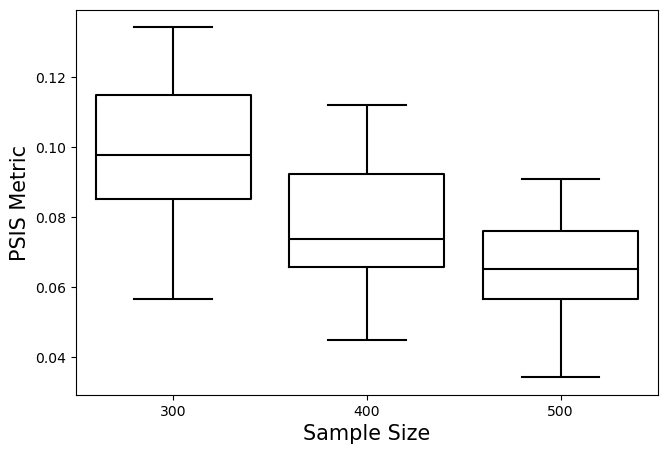

In [4]:
with open(r"alphas.pkl", "rb") as input_file:
    alpha_dict = pickle.load(input_file)

fig, axs = plt.subplots(1, 1, figsize = (7.5,5))
alpha_frame = pd.DataFrame(alpha_dict)
sns.boxplot(data= alpha_frame, ax = axs, fill = False, color = "black")
axs.set_ylabel("PSIS Metric", fontsize = 15)
axs.set_xlabel("Sample Size", fontsize= 15)
plt.savefig("paper_plots/psis_test.png", dpi = 500)